<a href="https://colab.research.google.com/github/fjadidi2001/Image_Inpaint/blob/main/FastInpaintingNet-Jan25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
from datasets import load_dataset
import pandas as pd

# Load the CelebA-HQ dataset
ds = load_dataset("saitsharipov/CelebA-HQ")

# Check if dataset loaded correctly
if ds is None:
    raise ValueError("Dataset not loaded correctly")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/224 [00:00<?, ?B/s]

(…)-00000-of-00003-30fbdf94a5d8e722.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

(…)-00001-of-00003-74b418aa7a721747.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

(…)-00002-of-00003-4f9459a488896f53.parquet:   0%|          | 0.00/465M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/202599 [00:00<?, ? examples/s]

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['image'],
        num_rows: 202599
    })
})

First few items in the training set:
Item 0:
  image: Image with shape (178, 218)


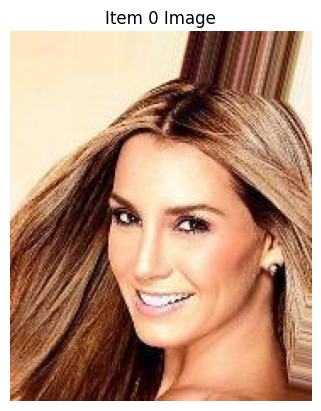


Item 1:
  image: Image with shape (178, 218)


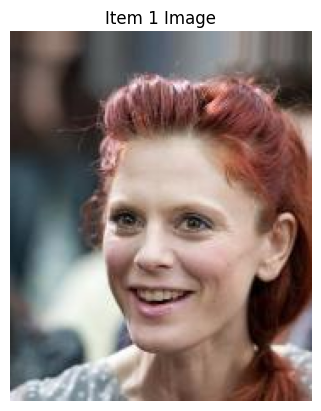


Item 2:
  image: Image with shape (178, 218)


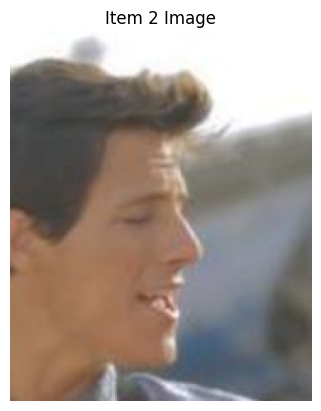


Item 3:
  image: Image with shape (178, 218)


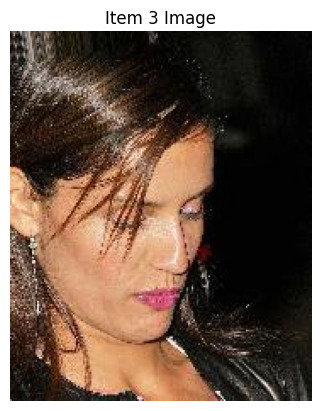


Item 4:
  image: Image with shape (178, 218)


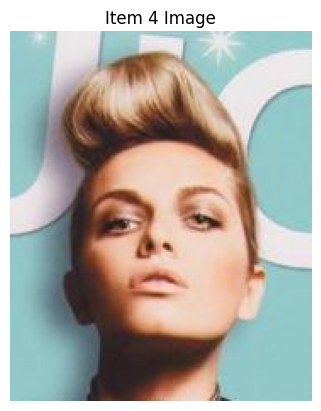



Column names:
['image']

DataFrame head:
                                               image
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...
3  <PIL.JpegImagePlugin.JpegImageFile image mode=...
4  <PIL.JpegImagePlugin.JpegImageFile image mode=...

Column data types:
image    object
dtype: object


In [3]:
from datasets import load_dataset
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Load the CelebA-HQ dataset
try:
    ds = load_dataset("saitsharipov/CelebA-HQ")
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()

# Print basic information about the dataset
print("Dataset structure:")
print(ds)

# Inspect the first few items in the training set
print("\nFirst few items in the training set:")
for i, item in enumerate(ds['train'].take(5)):
    print(f"Item {i}:")
    for key, value in item.items():
        if key == 'image':
            print(f"  {key}: Image with shape {value.size}")
            # Display the image
            plt.imshow(value)
            plt.title(f"Item {i} Image")
            plt.axis('off')
            plt.show()
        else:
            print(f"  {key}: {value}")
    print()

# Get all column names (attributes)
column_names = list(ds['train'].features.keys())
print("\nColumn names:")
print(column_names)

# Convert a small subset of the dataset to a pandas DataFrame for easier inspection
df = pd.DataFrame(ds['train'].select(range(100)))
print("\nDataFrame head:")
print(df.head())

# Print data types of columns
print("\nColumn data types:")
print(df.dtypes)

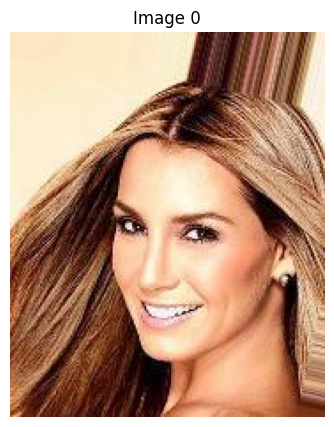

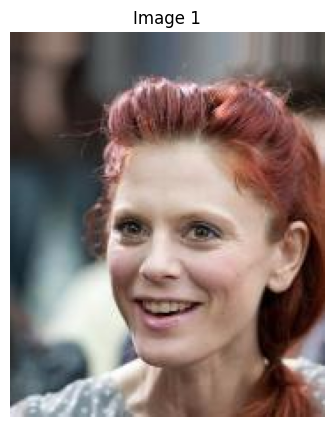

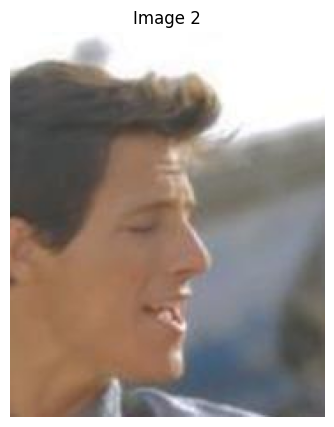

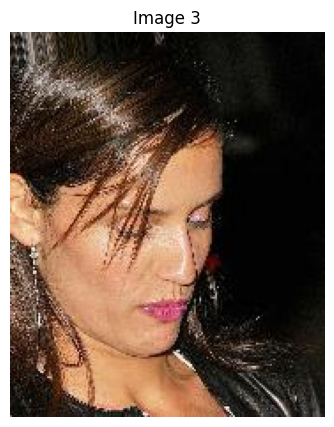

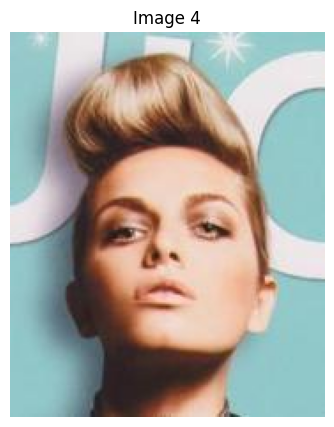

In [4]:
import matplotlib.pyplot as plt

# Display the first 5 images
for i, item in enumerate(ds['train'].take(5)):
    plt.figure(figsize=(5, 5))
    plt.imshow(item['image'])
    plt.title(f"Image {i}")
    plt.axis('off')
    plt.show()

In [5]:
for i, item in enumerate(ds['train'].take(5)):
    print(f"Image {i}:")
    print(f"  Size: {item['image'].size}")
    print(f"  Mode: {item['image'].mode}")
    print(f"  Format: {item['image'].format}")

Image 0:
  Size: (178, 218)
  Mode: RGB
  Format: JPEG
Image 1:
  Size: (178, 218)
  Mode: RGB
  Format: JPEG
Image 2:
  Size: (178, 218)
  Mode: RGB
  Format: JPEG
Image 3:
  Size: (178, 218)
  Mode: RGB
  Format: JPEG
Image 4:
  Size: (178, 218)
  Mode: RGB
  Format: JPEG


In [6]:
import numpy as np

# Convert the first image to a NumPy array
image_array = np.array(ds['train'][0]['image'])
print(f"Image array shape: {image_array.shape}")
print(f"Image array:\n{image_array}")

Image array shape: (218, 178, 3)
Image array:
[[[253 231 194]
  [253 231 194]
  [253 231 194]
  ...
  [246 228 216]
  [255 237 223]
  [254 238 222]]

 [[253 231 194]
  [253 231 194]
  [253 231 194]
  ...
  [248 230 218]
  [255 237 223]
  [254 238 222]]

 [[253 231 194]
  [253 231 194]
  [253 231 194]
  ...
  [250 232 220]
  [255 238 224]
  [255 239 223]]

 ...

 [[140  74  26]
  [115  49   1]
  [146  78  33]
  ...
  [122  55  28]
  [123  56  30]
  [122  56  30]]

 [[130  62  15]
  [138  70  23]
  [166  98  53]
  ...
  [118  49  20]
  [120  50  24]
  [118  51  24]]

 [[168 100  53]
  [204 136  89]
  [245 177 132]
  ...
  [118  49  20]
  [120  50  24]
  [120  50  24]]]


In [7]:
from torchvision import transforms

# Define a transformation to resize images
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128
    transforms.ToTensor(),          # Convert to tensor
])

# Apply the transformation to the first image
image_resized = transform(ds['train'][0]['image'])
print(f"Resized image shape: {image_resized.shape}")

Resized image shape: torch.Size([3, 128, 128])


In [8]:
import os

# Create a directory to save images
os.makedirs("celeba_images", exist_ok=True)

# Save the first 10 images
for i, item in enumerate(ds['train'].take(10)):
    item['image'].save(f"celeba_images/image_{i}.jpg")

In [9]:
# Compute mean and standard deviation of pixel values
pixel_values = np.array([np.array(item['image']) for item in ds['train'].take(1000)])
mean = np.mean(pixel_values, axis=(0, 1, 2)) / 255
std = np.std(pixel_values, axis=(0, 1, 2)) / 255

print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")

Mean: [0.51233411 0.43074377 0.38637948]
Standard Deviation: [0.31153927 0.29096617 0.29042072]


In [10]:
def create_irregular_mask(image_size, max_vertices=8, max_brush_width=30):
    """
    Create an irregular mask with random shapes.

    Args:
        image_size (tuple): Size of the image (height, width).
        max_vertices (int): Maximum number of vertices for random polygons.
        max_brush_width (int): Maximum brush width for drawing shapes.

    Returns:
        mask (numpy.ndarray): Binary mask (0 for masked regions, 1 for unmasked regions).
    """
    mask = np.ones(image_size, dtype=np.uint8)  # Start with a fully unmasked image

    # Draw random shapes
    num_shapes = np.random.randint(1, 5)  # Number of random shapes
    for _ in range(num_shapes):
        # Random vertices for a polygon
        vertices = np.random.randint(0, max(image_size), size=(np.random.randint(3, max_vertices), 2))
        # Draw the polygon on the mask
        cv2.fillPoly(mask, [vertices], color=0)

        # Draw random lines
        for _ in range(np.random.randint(1, 3)):
            pt1 = tuple(np.random.randint(0, max(image_size), size=2))
            pt2 = tuple(np.random.randint(0, max(image_size), size=2))
            cv2.line(mask, pt1, pt2, color=0, thickness=np.random.randint(1, max_brush_width))

    return mask

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

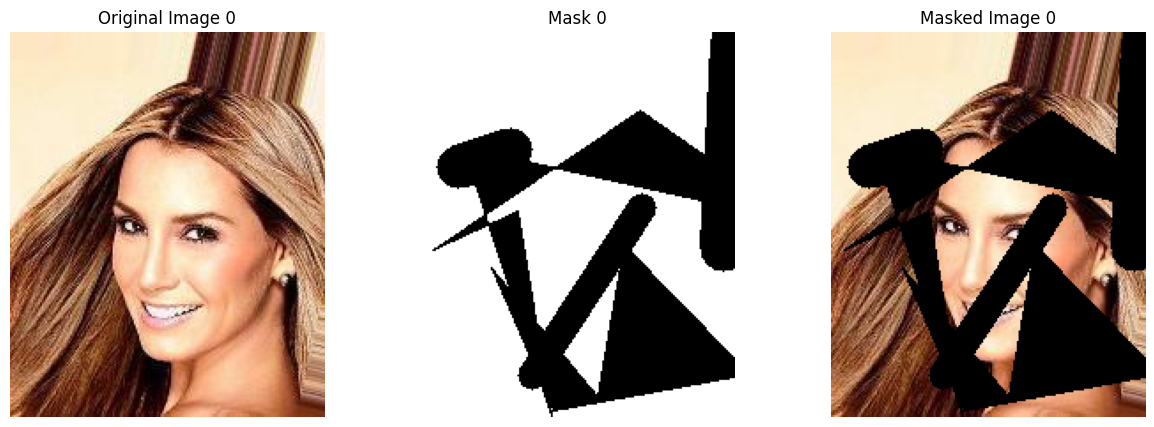

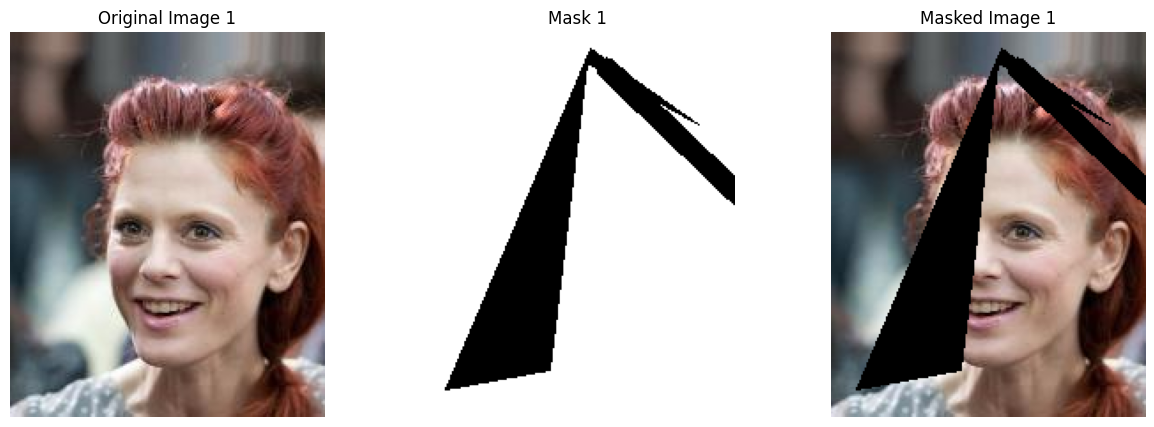

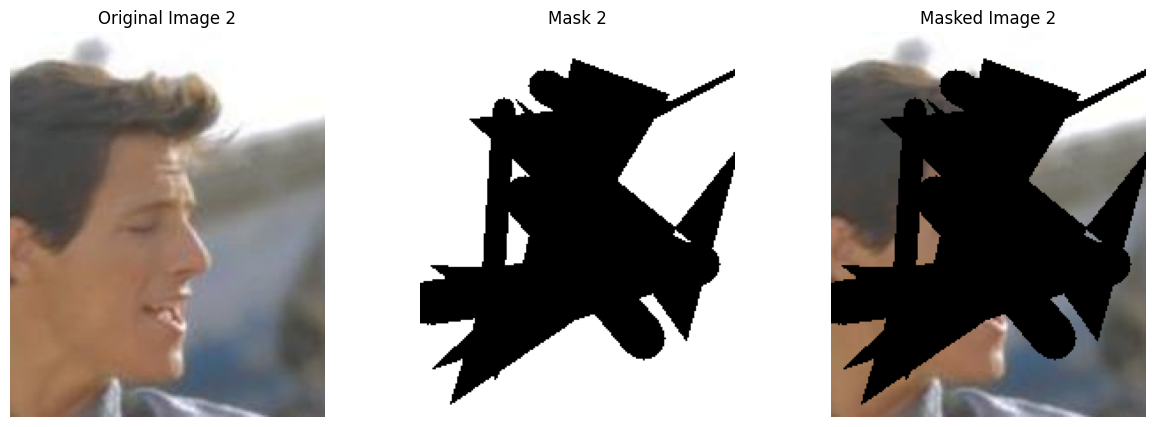

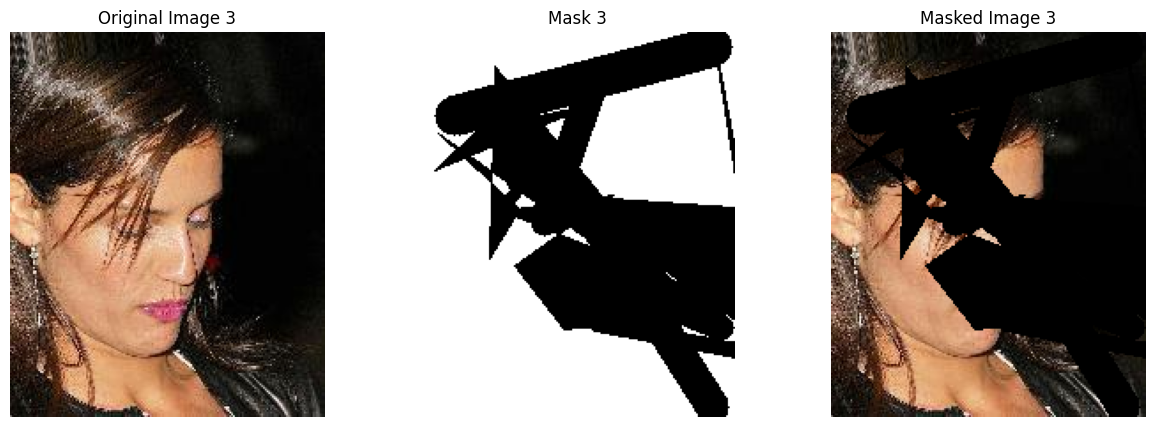

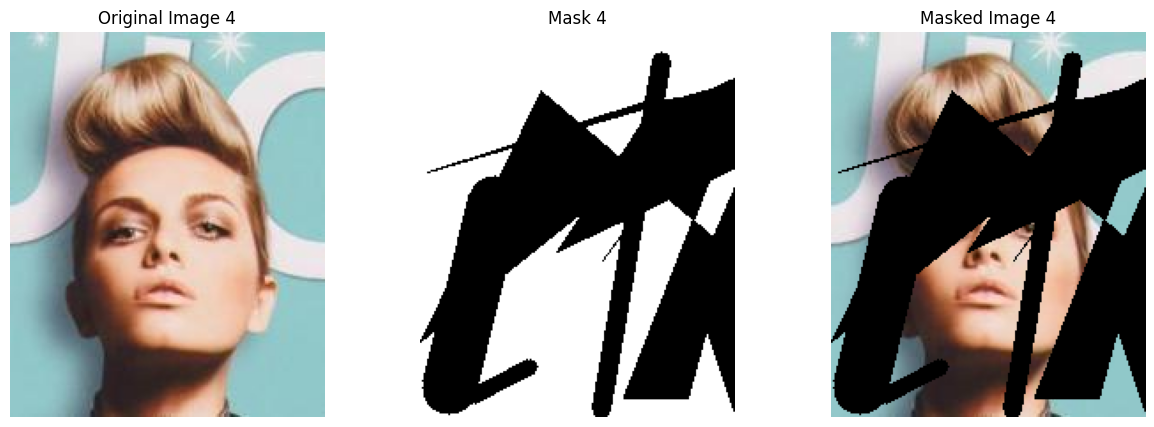

In [13]:
# Display the first 5 images with irregular masks
for i, item in enumerate(ds['train'].take(5)):
    image = np.array(item['image'])  # Convert PIL image to NumPy array
    mask = create_irregular_mask(image.shape[:2])  # Create mask

    # Apply the mask to the image
    masked_image = image * mask[:, :, np.newaxis]  # Multiply image with mask

    # Display the original image, mask, and masked image
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title(f"Original Image {i}")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title(f"Mask {i}")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(masked_image)
    plt.title(f"Masked Image {i}")
    plt.axis('off')

    plt.show()

In [14]:
!pip install diffusers transformers torch datasets

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
import numpy as np
import cv2
from datasets import load_dataset

# Load the CelebA-HQ dataset
ds = load_dataset("saitsharipov/CelebA-HQ")

def create_irregular_mask(image_size, max_vertices=8, max_brush_width=30):
    """
    Create an irregular mask with random shapes.

    Args:
        image_size (tuple): Size of the image (height, width).
        max_vertices (int): Maximum number of vertices for random polygons.
        max_brush_width (int): Maximum brush width for drawing shapes.

    Returns:
        mask (numpy.ndarray): Binary mask (0 for masked regions, 1 for unmasked regions).
    """
    mask = np.ones(image_size, dtype=np.uint8)  # Start with a fully unmasked image

    # Draw random shapes
    num_shapes = np.random.randint(1, 5)  # Number of random shapes
    for _ in range(num_shapes):
        # Random vertices for a polygon
        vertices = np.random.randint(0, max(image_size), size=(np.random.randint(3, max_vertices), 2))
        # Draw the polygon on the mask
        cv2.fillPoly(mask, [vertices], color=0)

        # Draw random lines
        for _ in range(np.random.randint(1, 3)):
            pt1 = tuple(np.random.randint(0, max(image_size), size=2))
            pt2 = tuple(np.random.randint(0, max(image_size), size=2))
            cv2.line(mask, pt1, pt2, color=0, thickness=np.random.randint(1, max_brush_width))

    return mask

In [17]:
from diffusers import StableDiffusionInpaintPipeline
import torch

# Load the pretrained inpainting model
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
).to("cuda")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

model_index.json:   0%|          | 0.00/544 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]